# Install dependacies and import libraries

Firstly we will need to install a few things, namely pytorch! Each time you run the notebook you'll need to reinstall.

In [1]:
# Url management.
import io
from six.moves.urllib.request import urlopen

# For teacher forcing.
import random

# Audio libraries.
import IPython
import librosa
import librosa.display

# A very useful numerical package.
import numpy as np

# NumPy on steriods.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

# Stats for outlier detection.
from scipy import stats
from sklearn import svm
from sklearn import decomposition
from sklearn.neighbors import LocalOutlierFactor

# To make nice plots.
import matplotlib.font_manager
import matplotlib.pyplot as plt

import lws

In [2]:
def to_var(x):
  if torch.cuda.is_available():
      x = x.cuda()
  return Variable(x)

# Build models

Now we build the generator and discriminator

In [3]:
class EncoderRNN(nn.Module):
  
  """The encoder takes a batch of FFT frame sequences and returns encodings.
  
  There are no embeddings as the inputs are already real values, and the
  objective is to take FFT frames sequences (batch_size, sequence_length,
  fft_size) and return the encodings (batch_size, sequence_length, hidden_size).
  """
  
  def __init__(self, 
               input_size, 
               batch_size,
               hidden_size, 
               number_layers=1, 
               dropout=0.1,
               bi_directional=True,
               rnn=nn.GRU):
    
    """The __init__ function.

    Sets up the encoder with the specified amount of layers and hidden size.
    Uses a different mask for each timestep, which has been shown to perform
    worse than if the mask was the same, for diffent layers at different
    timesteps as in https://arxiv.org/abs/1512.05287. So be wary of this! To
    entirely cancel out the dropout, just set dropout to zero.
    
    Arguments:
      input_size: Size of the input FFT frames.
      hidden_size: Size of the hidden learnable weights for the RNN.
      number_layers: How many layers the encoding RNN should have.
      dropout: Zero for no dropout, one for complete dropout.
      bi_directional: Whether or not the RNN should run in two directions.
      rnn_type: Pass a RNN module here such as nn.GRU or nn.LSTM.
    """
    
    super(EncoderRNN, self).__init__()
    
    self.input_size = input_size
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.bi_directional = bi_directional
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=number_layers, 
                   bidirectional=bi_directional,
                   batch_first=True)
    
    
  def forward(self, x, hidden):
    """The forward propoagation function. 
    
    The 
    """
    
    x, hidden = self.rnn(x, hidden)
    
    # linearly sum bi-directional outputs if appropriate.
    if self.bi_directional:
      forward = x[:, :, :self.hidden_size]
      backward = x[:, : ,self.hidden_size:]
      x = forward + backward
    
    return x, hidden
  
  
  def init_hidden(self):
    """"""
    amount = 2 if self.bi_directional else 1
    tensor = torch.FloatTensor(self.number_layers * amount, 
                               self.batch_size, 
                               self.hidden_size)
    return to_var(tensor.fill_(0))

  
  
class Attention(nn.Module):
  
  """An attention module that can switch between different scoring methods.
  
  The general form of the attention calculation uses the target decoder hidden
  state and the encoder state.
  
  Find the scoring methods here: https://arxiv.org/abs/1508.04025. The options
  are; 'dot', a dot product between the decoder and encoder state; 'general', 
  the dot product between the decoder state and a linear transform of the
  encoder state; 'concat', a dot product between a new parameter 'v' and a 
  linear transform of the states concatenated together. Finally the result is
  normalised.
  """
  
  def __init__(self, method, batch_size, hidden_size, bias=True):
    super(Attention, self).__init__()
    
    self.method = method
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    
    
    
    if self.method == 'general':
      self.attention = nn.Linear(hidden_size, hidden_size, bias=bias)
      
    elif self.method == 'concat':
      self.attention = nn.Linear(hidden_size * 2, hidden_size, bias=bias)
      self.v = nn.Parameter(torch.FloatTensor(batch_size, 1, hidden_size))
      
    
  def forward(self, hidden, encoder_outputs):
    max_length = encoder_outputs.size(1)
    
    if self.method == 'general':
      attention_energies = self.attention(encoder_outputs).transpose(2, 1)
      attention_energies = hidden.bmm(attention_energies)
    
    elif self.method == 'concat':
      # Broadcast hidden to encoder_outputs size.
      hidden *= to_var(encoder_outputs.data.new(encoder_outputs.size()).fill_(1))
      concat = torch.cat((hidden, encoder_outputs), -1)
      attention_energies = self.attention(concat)
      
      # Swap the second and first dimensions. 
      attention_energies = attention_energies.transpose(2, 1)
      attention_energies = self.v.bmm(attention_energies)
      
    else:
      # Method is 'dot'.
      encoder_outputs = encoder_outputs.transpose(2, 1)
      attention_energies = hidden.bmm(encoder_outputs)
      
    return F.softmax(attention_energies)
    
  
  
  def score(self, hidden, encoder_output):
    
    if self.method == 'dot':
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'general':
      energy = self.attention(encoder_output)
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'concat':
      concat = torch.cat((hidden, encoder_output), 1)
      energy = self.attention(concat)
      energy = self.v.dot(energy)
      
    return energy
      
        

class AttentionDecoderRNN(nn.Module):
  
  """Luong Attention Decoder RNN module.
  
  This decoder plugs in the Attention module ater the RNN to calculate the """
  
  def __init__(self, 
               attention_method,
               batch_size,
               hidden_size, 
               output_size, 
               number_layers=1, 
               dropout=0.1):
    
    super(AttentionDecoderRNN, self).__init__()
    
    self.attention_method = attention_method
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.number_layers = number_layers
    self.dropout = dropout
    
    self.rnn = nn.GRU(hidden_size, 
                      hidden_size, 
                      number_layers, 
                      dropout=dropout, 
                      batch_first=True)
    
    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.output = nn.Linear(hidden_size, output_size)
    
    self.attention = Attention(attention_method, batch_size, hidden_size)
    
    
  def forward(self, input_sequence, last_hidden, encoder_outputs):
    
    # Get current hidden state from input sequence and last hidden state.
    rnn_output, hidden = self.rnn(input_sequence, last_hidden)
    
    # Calculate attention from the current RNN state and all encoder outputs.
    attention_weights = self.attention(rnn_output, encoder_outputs)
    
    # bmm = batch matrix matrix product. Apply attention to encoder outputs to
    # get the weighted average.
    context = attention_weights.bmm(encoder_outputs)
    
    # Attentional vector using the RNN hidden state and context vector
    # concatenated together (Luong eq. 5).
    concat_input = torch.cat((rnn_output, context), -1)
    concat_output = F.tanh(self.concat(concat_input))
    
    # Finally predict next frame (Luong eq. 6, without softmax).
    output = self.output(concat_output)
    
    # Return final output, hidden state, and attention weights. We can use the
    # attention weights for visualisation.
    return output, hidden, attention_weights

# Test the encoder and decoder

In [4]:
if False:
  test_hidden_size     = 32
  test_input_size      = 32
  test_number_layers   = 3
  test_batch_size      = 16
  test_sequence_length = 7

  encoder_test = EncoderRNN(input_size=test_input_size,
                            batch_size=test_batch_size,
                            hidden_size=test_hidden_size,
                            number_layers=test_number_layers)
  
  decoder_test = AttentionDecoderRNN(attention_method='general',
                                     batch_size=test_batch_size,
                                     hidden_size=test_hidden_size,
                                     output_size=test_input_size,
                                     number_layers=test_number_layers)

  if torch.cuda.is_available():
    encoder_test.cuda()
    decoder_test.cuda()

  test_input_batches = to_var(torch.zeros(test_batch_size,
                                          test_sequence_length, 
                                          test_input_size))
  test_target_batches = to_var(torch.zeros(test_batch_size,
                                           test_sequence_length, 
                                           test_input_size))

  test_encoder_hidden = encoder_test.init_hidden()
  test_encoder_outputs, test_encoder_hidden = encoder_test(test_input_batches, 
                                                           test_encoder_hidden)

  # (batch_size, sequence_length, hidden_size)
  print('encoder outputs size      {}'.format(tuple(test_encoder_outputs.size())))

  # (number_layers * num_directions, sequence_length, hidden_size)
  print('encoder hidden state size {}'.format(tuple(test_encoder_hidden.size())))

  test_decoder_input = to_var(torch.zeros(test_batch_size, 
                                          test_sequence_length, 
                                          test_hidden_size))
  test_decoder_hidden = test_encoder_hidden[:decoder_test.number_layers]
 

  test_decoder_output, test_decoder_hidden, test_decoder_attention = \
    decoder_test(test_decoder_input, test_decoder_hidden, test_encoder_outputs)

  test_criterion = nn.MSELoss()
  test_loss = test_criterion(test_decoder_output, test_target_batches)
  print(test_loss.data[0])

# Utilites

You can look for music urls [here](https://www.jewelbeat.com/free/free-background-music.htm)

In [5]:
class AudioDataset():
    """A class to convert audio found at an url to magnitude frames."""

    def __init__(self,
                 fft_size,
                 hop_length,
                 batch_size,
                 sequence_length,
                 path=None,
                 limit=None):

        self.fft_size = fft_size
        self.feature_size = (fft_size // 2) + 1
        self.hop_length = hop_length

        self.data, self.sample_rate = librosa.load(path, mono=True)

        if limit is not None:
            self.data = self.data[:limit * self.sample_rate]

        # Get features to train on.
        self.stfts = librosa.stft(self.data,
                                  n_fft=fft_size,
                                  hop_length=hop_length)
        self.magnitudes, _ = librosa.magphase(self.stfts.T)

        self.dataset_size = len(self.magnitudes) - sequence_length * 2 - 1
        input_shape = (self.dataset_size, sequence_length, self.feature_size)
        target_shape = input_shape
        self.batch_size = batch_size
        self.x = np.zeros(input_shape, dtype=np.float32)
        self.y = np.zeros(target_shape, dtype=np.float32)

        for i, x_start in enumerate(range(0, self.dataset_size)):
            y_start = x_end = x_start + sequence_length
            y_end = y_start + sequence_length

            self.x[i] = self.magnitudes[x_start:x_end]
            self.y[i] = self.magnitudes[y_start:y_end]

    def get_next_batch(self, amount_epochs):

        for epoch in range(amount_epochs):

            permuation = np.random.permutation(len(self.x))
            x, y = self.x[permuation], self.y[permuation]

            for start in range(0, len(x) - self.batch_size, self.batch_size):
                end = start + self.batch_size

                batch_x = torch.from_numpy(x[start:end])
                batch_y = torch.from_numpy(y[start:end])

                yield to_var(batch_x), to_var(batch_y), epoch
        
        
        
def griffin_lim(spectrogram, n_iter=100, window='hann', n_fft=2048, hop_length=-1):
  if hop_length == -1:
    hop_length = n_fft // 4

  angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

  for i in range(n_iter):
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
    angles = np.exp(1j * np.angle(rebuilt))

  full = np.abs(spectrogram).astype(np.complex) * angles
  inverse = librosa.istft(full, hop_length = hop_length, window = window)

  return inverse
    
  
  
def outlier_detection(data, 
                      contamination_fraction=0.25, 
                      amount_neighbours=35, 
                      figure_width=8,
                      append_covariance=False,
                      inline=False):
  
  # Get rank-2 data points.
  number_data_points = len(data)
  data = np.array(data).reshape((number_data_points, -1))

  # perform dimensionality reduction if necessary for visualisation.
  if data.shape[1] > 2:
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    data = pca.transform(data)
    
  # Setup.
  xx, yy = np.meshgrid(np.linspace(data.min(), data.max(), 100), 
                       np.linspace(data.min(), data.max(), 100))
    
  # Instanciate outlier detection methods and find anomolies & descision bounds.
  lof = LocalOutlierFactor(n_neighbors=amount_neighbours,
                           contamination=contamination_fraction)
  lof_predictions = lof.fit_predict(data)
  lof_scores_pred = lof.negative_outlier_factor_
  lof_threshold = stats.scoreatpercentile(lof_scores_pred, 
                                          100 * contamination_fraction)
  lof_z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
  
  # Plot everything.
  plot_data = [
      ('Local Outlier Factor', lof_z, lof_threshold, lof_predictions)
  ]
  
  # Add robust covarince method. Need fix decision boundary!
  if append_covariance:
    env = EllipticEnvelope(contamination=contamination_fraction)
    env.fit(data)
    env_predictions = env.decision_function(data)
    env_scores_pred = env.predict(data)
    env_threshold = stats.scoreatpercentile(env_scores_pred,
                                            100 * contamination_fraction)
    env_z = env.decision_function(np.c_[xx.ravel(), yy.ravel()])
    cova_data = ('Robust Covariance', env_z, env_threshold, env_scores_pred)
    plot_data.append(cova_data)
    
  fig = plt.figure(figsize=(figure_width, figure_width * len(plot_data)))
  plot_number = 1
  for title, z, threshold, predictions in plot_data:
    z = z.reshape(xx.shape)
    sub_plot = fig.add_subplot(len(plot_data), 1, plot_number)
    sub_plot.contourf(xx, yy, z, levels=np.linspace(z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    sub_plot.contour(xx, yy, z, levels=[threshold], linewidths=2, colors='red')
    sub_plot.contourf(xx, yy, z, levels=[threshold, z.max()], colors='orange')

    inliers = data[np.where(predictions == 1)]
    outliers = data[np.where(predictions == -1)]
    sub_plot.scatter(inliers[:,0], inliers[:,1], c='white', s=20, edgecolor='k')
    sub_plot.scatter(outliers[:,0], outliers[:,1], c='black', s=20, edgecolor='k')

    sub_plot.axis('tight')
    sub_plot.set_xlabel(title)
    sub_plot.set_xlim((data.min(), data.max()))
    sub_plot.set_ylim((data.min(), data.max()))
    
    plot_number += 1
  
  # Convert to NumPy array and return!
  fig.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
  fig.suptitle("Outlier detection")
  
  if not inline:
    plt.close()
  else:
    fig.savefig('outlier_detection.png', dpi=fig.dpi)
  
  return fig, np.where(lof_predictions == -1)[0]



def plot_audio(data):
  plt.figure()
  stft = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
  librosa.display.specshow(stft, y_axis='log')
  plt.show()
  

# Train and inference functions

In [6]:
def train(encoder, 
          decoder, 
          encoder_optimiser,
          decoder_optimiser, 
          input_batch, 
          target_batch,
          criterion,
          clip_threshold):
  
  # Zero the gradients of both optimisers.
  encoder_optimiser.zero_grad()
  decoder_optimiser.zero_grad()
  
  batch_size, sequence_length, fft_size = tuple(input_batch.size())
  
  # Run the input batch of fft sequences through the encoder.
  encoder_hidden = encoder.init_hidden()
  encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)
  
  # Prepare the input and output variables.
  decoder_input = input_batch
  decoder_hidden = encoder_hidden[:decoder.number_layers]
  
  decoder_output, decoder_hidden, decoder_attention = \
    decoder(decoder_input, decoder_hidden, encoder_outputs)
   
  # How close were we to the targets?
  loss = criterion(decoder_output, target_batch)
  loss.backward()
  
  # Clip the gradient norms.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip_threshold)
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip_threshold)
  
  # Update parameters with optimisers.
  encoder_optimiser.step()
  decoder_optimiser.step()
  
  return loss.data[0]   

In [7]:
def run(encoder, 
        decoder, 
        start_sequences,
        amount_frames,
        init_hidden_once=True):
  
  encoder.train(False)
  decoder.train(False)
  
  # Get random sequence from dataset object. 
  batch_size, sequence_length, fft_size = start_sequences.size()
  model_input = start_sequences.view(batch_size, sequence_length, fft_size)
  
  frames = np.zeros((amount_frames, batch_size, sequence_length, fft_size))

  if init_hidden_once:
    encoder_hidden = encoder.init_hidden()

  # Repeatedly sample the RNN and get the output.
  for i in range(amount_frames):

    if not init_hidden_once:
      encoder_hidden = encoder.init_hidden()
    
    encoder_outputs, encoder_hidden = encoder(model_input, encoder_hidden)

    decoder_input = model_input
    decoder_hidden = encoder_hidden[:decoder.number_layers]

    decoder_output, decoder_hidden, _ = \
      decoder(decoder_input, decoder_hidden, encoder_outputs)

    model_input = decoder_output    
    frames[i] = Variable(decoder_output.data).cpu().data.numpy()

  encoder.train(True)
  decoder.train(True)

  return frames.reshape((batch_size, -1, fft_size))


# Hyper parameters

In [8]:
!ls massive_chops/trimmed

atmos_trimmed.wav  harpsi_trimmed.wav	  piano_trimmed.wav
bass_trimmed.wav   mellotron_trimmed.wav  vocals_trimmed.wav
drums_trimmed.wav  organ_trimmed.wav


Settings Done.
Encoder Done.
Decoder Done.


/home/eavi/leon/leon/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


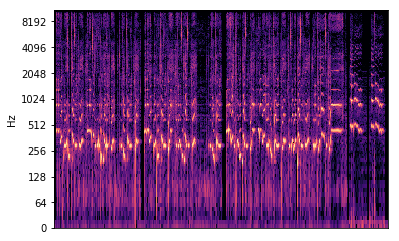

In [9]:
# Hyper parameters.
seed                   = 42
attention_method       = 'general'
fft_size               = 1024
number_layers          = 3
dropout                = 0.0
sequence_length        = 150 # was 50, 150
clip_threshold         = 5.0
criterion              = nn.MSELoss()
learning_rate          = 0.00001
decoder_learning_ratio = 5.0
batch_size             = 8 # was 64
number_epochs          = 20
evaluate_every_epoch   = 5
feature_size = input_size = hidden_size = (fft_size // 2) + 1
hop_length = fft_size // 4

path = "./massive_chops/trimmed/vocals_trimmed.wav"

print("Settings Done.")

# Construct RNNs and optimisers.
encoder = EncoderRNN(input_size=feature_size,
                     batch_size=batch_size,
                     hidden_size=feature_size,
                     number_layers=number_layers,
                     dropout=dropout)

print("Encoder Done.")

decoder = AttentionDecoderRNN(attention_method,
                              batch_size=batch_size,
                              hidden_size=hidden_size,
                              output_size=feature_size,
                              number_layers=number_layers,
                              dropout=dropout)

print("Decoder Done.")

# Enable GPU tensors provided GPUs actually exist!
if torch.cuda.is_available():
  encoder.cuda()
  decoder.cuda()
  criterion.cuda()
  torch.cuda.manual_seed(seed)
else:
  torch.manual_seed(seed)
  
encoder_optimiser = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimiser = torch.optim.Adam(decoder.parameters(), 
                                     lr=learning_rate * decoder_learning_ratio)

dataset = AudioDataset(fft_size=fft_size,
                       hop_length=hop_length,
                       batch_size=batch_size,
                       sequence_length=sequence_length,
                       path=path)

# Plot and listen to the audio.
plot_audio(dataset.data) 
IPython.display.Audio(dataset.data, rate=dataset.sample_rate)

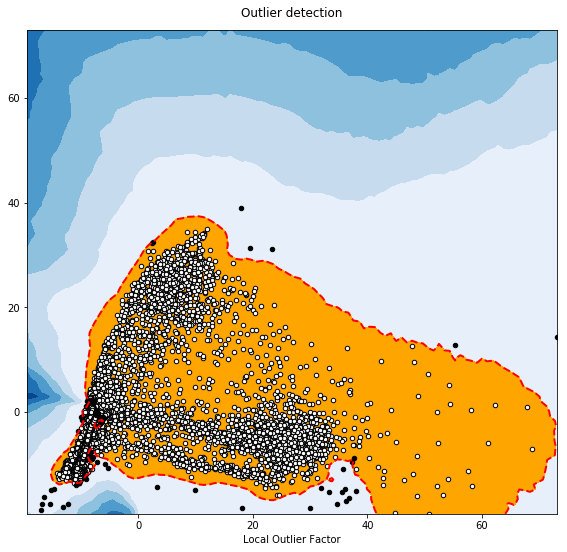

In [ ]:
_ = outlier_detection(dataset.magnitudes, contamination_fraction=0.01, inline=True)

In [ ]:
indices = np.random.permutation(dataset.dataset_size)[:batch_size]
start_sequences = to_var(torch.from_numpy(dataset.x[indices]))

previous_epoch = -1

for x, y, epoch in dataset.get_next_batch(number_epochs):

#   if previous_epoch != epoch and epoch % evaluate_every_epoch == 0:
#     predicted_batch = run(encoder, decoder, start_sequences, 20)
#     for i in range(1):
#       predicted_audio = griffin_lim(predicted_batch[i].T, 
#                                     n_iter=100, 
#                                     window='hann', 
#                                     n_fft=fft_size, 
#                                     hop_length=hop_length)
#       plot_audio(predicted_audio) 
#     previous_epoch = epoch

  loss = train(encoder, 
               decoder, 
               encoder_optimiser,
               decoder_optimiser,
               x, 
               y,
               criterion, 
               clip_threshold)
  print("epoch {}/{}, loss {}".format(epoch, number_epochs, loss))


/home/eavi/leon/leon/lib/python3.5/site-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/20, loss 1.1329237222671509
epoch 0/20, loss 1.3834110498428345
epoch 0/20, loss 0.9196109771728516
epoch 0/20, loss 1.2406463623046875
epoch 0/20, loss 0.8996897339820862
epoch 0/20, loss 1.3152142763137817
epoch 0/20, loss 0.771161675453186
epoch 0/20, loss 1.3506922721862793
epoch 0/20, loss 1.1599370241165161
epoch 0/20, loss 1.0849566459655762
epoch 0/20, loss 1.1489399671554565
epoch 0/20, loss 1.087337613105774
epoch 0/20, loss 0.8921520709991455
epoch 0/20, loss 1.3575292825698853
epoch 0/20, loss 1.2082575559616089
epoch 0/20, loss 1.2449179887771606
epoch 0/20, loss 1.1886850595474243
epoch 0/20, loss 1.0238299369812012
epoch 0/20, loss 1.1957590579986572
epoch 0/20, loss 1.0114165544509888
epoch 0/20, loss 0.7836304306983948
epoch 0/20, loss 0.8889989256858826
epoch 0/20, loss 1.0153100490570068
epoch 0/20, loss 1.1701585054397583
epoch 0/20, loss 1.220064401626587
epoch 0/20, loss 1.4873464107513428
epoch 0/20, loss 1.0038601160049438
epoch 0/20, loss 1.059003353118

KeyboardInterrupt: 

In [ ]:
predicted_batch = run(encoder, decoder, start_sequences, 20)

In [ ]:
first_magnitudes = predicted_batch[0].T

first_magnitudes_clip = first_magnitudes.copy()
# first_magnitudes_clip[first_magnitudes_clip < 0.0] = 0.00

print("First Magnitudes Shape", first_magnitudes.shape)

lws_processor_speech = lws.lws(fft_size, hop_length, mode='speech')
lws_processor_music  = lws.lws(fft_size, hop_length, mode='music')

print("mags min", np.min(first_magnitudes_clip))

# Local Weighted Sums.
lws_predicted_audio_speech = lws_processor_speech.run_lws(first_magnitudes_clip.T)
lws_predicted_audio_music  = lws_processor_music.run_lws(first_magnitudes_clip.T)

In [ ]:
# Griffin Lim.
gl_predicted_audio_a = griffin_lim(first_magnitudes, 
                                   n_iter=100, 
                                   window='hann', 
                                   n_fft=fft_size, 
                                   hop_length=hop_length)
gl_predicted_audio_b = griffin_lim(first_magnitudes, 
                                   n_iter=150, 
                                   window='hann', 
                                   n_fft=fft_size, 
                                   hop_length=hop_length)
gl_predicted_audio_c = griffin_lim(first_magnitudes, 
                                   n_iter=200, 
                                   window='hann', 
                                   n_fft=fft_size, 
                                   hop_length=hop_length)

In [ ]:
lws_predicted_audio_music_frames_librosa = \
    librosa.istft(lws_predicted_audio_music.T, hop_length=hop_length, win_length=fft_size)
    
lws_predicted_audio_speech_frames_librosa = \
    librosa.istft(lws_predicted_audio_speech.T, hop_length=hop_length, win_length=fft_size)
    
lws_predicted_audio_music_frames_lws = \
    lws_processor_music.istft(lws_predicted_audio_music)
    
lws_predicted_audio_speech_frames_lws = \
    lws_processor_speech.istft(lws_predicted_audio_speech)

In [ ]:
plot_audio(lws_predicted_audio_speech_frames_lws) 

IPython.display.Audio(lws_predicted_audio_speech_frames_lws, rate=dataset.sample_rate)

In [ ]:
plot_audio(lws_predicted_audio_speech_frames_librosa) 

IPython.display.Audio(lws_predicted_audio_speech_frames_librosa, rate=dataset.sample_rate)

In [ ]:
plot_audio(lws_predicted_audio_music_frames) 

IPython.display.Audio(lws_predicted_audio_music_frames, rate=dataset.sample_rate)

In [ ]:
plot_audio(gl_predicted_audio_a) 

IPython.display.Audio(gl_predicted_audio_a, rate=dataset.sample_rate)

In [ ]:
plot_audio(gl_predicted_audio_b) 

IPython.display.Audio(gl_predicted_audio_b, rate=dataset.sample_rate)

In [ ]:
plot_audio(gl_predicted_audio_c) 

IPython.display.Audio(gl_predicted_audio_c, rate=dataset.sample_rate)

In [ ]:
predicted_batch = run(encoder, decoder, start_sequences, 20)

predicted_audio_a = griffin_lim(predicted_batch[0].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_a) 

IPython.display.Audio(predicted_audio_a, rate=dataset.sample_rate)

In [ ]:
predicted_audio_b = griffin_lim(predicted_batch[1].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_b) 

IPython.display.Audio(predicted_audio_b, rate=dataset.sample_rate)

In [ ]:
predicted_audio_c = griffin_lim(predicted_batch[2].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_c) 

IPython.display.Audio(predicted_audio_c, rate=dataset.sample_rate)

In [ ]:
predicted_audio_d = griffin_lim(predicted_batch[3].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_d) 

IPython.display.Audio(predicted_audio_d, rate=dataset.sample_rate)